# 带有配置文件模式的聊天机器人（Chatbot with Profile Schema）

## 评审（Review）

We introduced the [LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) as a way to save and retrieve long-term memories.

我们介绍了 [LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) 作为一种保存和检索长期记忆的方法。

We built a simple chatbot that uses both `short-term (within-thread)` and `long-term (across-thread)` memory.

我们构建了一个简单的聊天机器人，它同时使用了 `short-term (within-thread)` 和 `long-term (across-thread)` 内存。

It saved long-term [semantic memory](https://langchain-ai.github.io/langgraph/concepts/memory/#semantic-memory) (facts about the user) ["in the hot path"](https://langchain-ai.github.io/langgraph/concepts/memory/#writing-memories), as the user is chatting with it.

它保存了长期的 [semantic memory](https://langchain-ai.github.io/langgraph/concepts/memory/#semantic-memory)（关于用户的事实）["in the hot path"](https://langchain-ai.github.io/langgraph/concepts/memory/#writing-memories)，当用户与其聊天时。

## 目标（Goals）

Our chatbot saved memories as a string. In practice, we often want memories to have a structure. 
 
For example, memories can be a [single, continuously updated schema]((https://langchain-ai.github.io/langgraph/concepts/memory/#profile)). 
 
In our case, we want this to be a single user profile.
 
We'll extend our chatbot to save semantic memories to a single [user profile](https://langchain-ai.github.io/langgraph/concepts/memory/#profile). 

我们的聊天机器人将记忆保存为字符串。在实际应用中，我们通常希望记忆具有结构。

例如，记忆可以是 [single, continuously updated schema]((https://langchain-ai.github.io/langgraph/concepts/memory/#profile))。

在我们的例子中，我们希望这是一个单一的用户配置文件。

我们将扩展我们的聊天机器人，以将语义记忆保存到单一的 [user profile](https://langchain-ai.github.io/langgraph/concepts/memory/#profile)。

We'll also introduce a library, [Trustcall](https://github.com/hinthornw/trustcall), to update this schema with new information. 

我们还将介绍一个库 [Trustcall](https://github.com/hinthornw/trustcall)，用于使用新信息更新此模式。



In [7]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall langchain_core

In [1]:
import os, getpass

def _set_env(var: str):
    # 检查环境变量是否已在操作系统中设置
    env_value = os.environ.get(var)
    if not env_value:
        # 如果未设置，则提示用户输入
        env_value = getpass.getpass(f"{var}: ")
    
    # 为当前进程设置环境变量
    os.environ[var] = env_value

_set_env("LANGSMITH_API_KEY")  # 设置LangSmith API密钥
os.environ["LANGSMITH_TRACING"] = "true"  # 启用LangSmith追踪
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"  # 设置LangSmith项目名称

## 定义用户配置文件模式（Defining a user profile schema）

Python has many different types for [structured data](https://python.langchain.com/docs/concepts/structured_outputs/#schema-definition), such as TypedDict, Dictionaries, JSON, and [Pydantic](https://docs.pydantic.dev/latest/). 

Python 有许多不同类型的 [structured data](https://python.langchain.com/docs/concepts/structured_outputs/#schema-definition)，例如 TypedDict、字典、JSON 和 [Pydantic](https://docs.pydantic.dev/latest/)。

Let's start by using TypedDict to define a user profile schema.

让我们先使用 TypedDict 来定义一个用户资料模式。



In [2]:
from typing import TypedDict, List

class UserProfile(TypedDict):
    """带有类型字段的用户档案模式"""
    user_name: str  # 用户的首选名称
    interests: List[str]  # 用户兴趣列表

## 将模式保存到存储中（Saving a schema to the store）

The [LangGraph Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) accepts any Python dictionary as the `value`. 

[LangGraph Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) 接受任何 Python 字典作为 `value`。



In [3]:
# TypedDict 实例
user_profile: UserProfile = {
    "user_name": "Lance",  # 用户名
    "interests": ["骑行", "科技", "咖啡"]  # 兴趣爱好
}
user_profile

{'user_name': 'Lance', 'interests': ['骑行', '科技', '咖啡']}

We use the [put](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.put) method to save the TypedDict to the store.

我们使用 [put](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.put) 方法将 TypedDict 保存到存储中。



In [4]:
import uuid
from langgraph.store.memory import InMemoryStore

# 初始化内存存储
in_memory_store = InMemoryStore()

# 为要保存的记忆创建命名空间
user_id = "1"
namespace_for_memory = (user_id, "memory")

# 将记忆以键值对的形式保存到命名空间中
key = "user_profile"
value = user_profile
in_memory_store.put(namespace_for_memory, key, value)

We use [search](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.search) to retrieve objects from the store by namespace.

我们使用 [search](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.search) 按命名空间从存储中检索对象。



In [5]:
# Search 
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['1', 'memory'], 'key': 'user_profile', 'value': {'user_name': 'Lance', 'interests': ['骑行', '科技', '咖啡']}, 'created_at': '2025-07-26T02:04:08.614489+00:00', 'updated_at': '2025-07-26T02:04:08.614494+00:00', 'score': None}


We can also use [get](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.get) to retrieve a specific object by namespace and key.

我们还可以使用 [get](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.get) 通过命名空间和键来检索特定对象。



In [6]:
# Get the memory by namespace and key
profile = in_memory_store.get(namespace_for_memory, "user_profile")
profile.value

{'user_name': 'Lance', 'interests': ['骑行', '科技', '咖啡']}

## 带有配置文件模式的聊天机器人（Chatbot with profile schema）

Now we know how to specify a schema for the memories and save it to the store.

现在我们知道了如何为记忆指定一个模式，并将其保存到存储中。

Now, how do we actually *create* memories with this particular schema?

现在，我们如何根据这个特定的模式 *创建* 记忆？

In our chatbot, we [want to create memories from a user chat](https://langchain-ai.github.io/langgraph/concepts/memory/#profile). 

在我们的聊天机器人中，我们 [想要从一个聊天里创建记忆](https://langchain-ai.github.io/langgraph/concepts/memory/#profile).

This is where the concept of [structured outputs](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) is useful. 

这就是 [structured outputs格式化输出](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) 概念有用的地方。

LangChain's [chat model](https://python.langchain.com/docs/concepts/chat_models/) interface has a [PROTECTED$11$](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) method to enforce structured output.

LangChain 的 [chat model](https://python.langchain.com/docs/concepts/chat_models/) 接口有一个 [PROTECTED$11$](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) 方法用于强制结构化输出。

This is useful when we want to enforce that the output conforms to a schema, and it parses the output for us.

这在我们需要确保输出符合某个模式时非常有用，而且它会为我们解析输出。



In [7]:
_set_env("OPENAI_API_KEY")

Let's pass the `UserProfile` schema we created to the `with_structured_output` method.

让我们将创建的 `UserProfile` 模式 传递给 `with_structured_output` 方法。

We can then invoke the chat model with a list of [messages](https://python.langchain.com/docs/concepts/messages/) and get a structured output that conforms to our schema.

然后，我们可以用一组 [messages](https://python.langchain.com/docs/concepts/messages/) 调用聊天模型，并获得符合我们模式的结构化输出。



In [9]:
from pydantic import BaseModel, Field

from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain_community.chat_models import ChatTongyi
# 初始化模型
# model = ChatOpenAI(
#     model="qwen-plus-2025-07-14",
#     api_key="sk-ba2dda3817f145d7af141fdf32e31d90",
#     base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"
# )

model=ChatTongyi(
    model="qwen-plus-2025-07-14",
    api_key="sk-ba2dda3817f145d7af141fdf32e31d90"
)

# 将模式绑定到模型
model_with_structure = model.with_structured_output(UserProfile)

# 调用模型生成符合模式的结构化输出
structured_output = model_with_structure.invoke([HumanMessage("我的名字是Lance，我喜欢骑自行车。")])
structured_output

{'user_name': 'Lance', 'interests': ['骑自行车']}

Now, let's use this with our chatbot.

现在，让我们在聊天机器人中使用它。

This only requires minor changes to the `write_memory` function. 

这只需要对 `write_memory` 函数进行轻微修改。

We use `model_with_structure`, as defined above, to produce a profile that matches our schema. 

我们使用 `model_with_structure`，如上所述，来生成一个与我们模式匹配的配置文件。



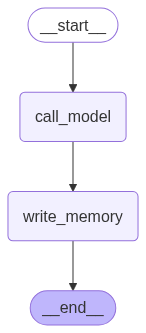

In [10]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.runnables.config import RunnableConfig

# 聊天机器人指令
MODEL_SYSTEM_MESSAGE = """你是一个拥有记忆功能的 helpful 助手，可以提供关于用户的信息。
如果你有这个用户的记忆，请使用它来个性化你的回复。
以下是记忆内容（可能为空）：{memory}"""

# 根据聊天历史和任何现有记忆创建新记忆
CREATE_MEMORY_INSTRUCTION = """根据用户的聊天历史创建或更新用户档案记忆。
这将被保存为长期记忆。如果存在现有记忆，只需更新它。
以下是现有记忆（可能为空）：{memory}"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """从存储中加载记忆并使用它来个性化聊天机器人的回复。"""
    
    # 从配置中获取用户ID
    user_id = config["configurable"]["user_id"]

    # 从存储中检索记忆
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # 为系统提示格式化记忆
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"姓名: {memory_dict.get('user_name', '未知')}\n"
            f"兴趣: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    # 在系统提示中格式化记忆
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # 使用记忆以及聊天历史来回复
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """反思聊天历史并将记忆保存到存储中。"""
    
    # 从配置中获取用户ID
    user_id = config["configurable"]["user_id"]

    # 从存储中检索现有记忆
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # 为系统提示格式化记忆
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"姓名: {memory_dict.get('user_name', '未知')}\n"
            f"兴趣: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None
        
    # 在指令中格式化现有记忆
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)

    # 调用模型生成符合模式的结构化输出
    new_memory = model_with_structure.invoke([SystemMessage(content=system_msg)]+state['messages'])

    # 覆盖现有的用户档案记忆
    key = "user_memory"
    store.put(namespace, key, new_memory)

# 定义图
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# 用于长期（跨线程）记忆的存储
across_thread_memory = InMemoryStore()

# 用于短期（线程内）记忆的检查点
within_thread_memory = MemorySaver()

# 使用检查点和存储编译图
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# 显示
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [11]:
# 我们提供线程ID用于短期（线程内）记忆
# 我们提供用户ID用于长期（跨线程）记忆 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# 用户输入 
input_messages = [HumanMessage(content="你好，我的名字是Lance，我喜欢在旧金山骑自行车和在面包店吃饭。")]

# 运行图
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

你好，我的名字是Lance，我喜欢在旧金山骑自行车和在面包店吃饭。
================================== Ai Message ==================================

你好，Lance！很高兴认识你。旧金山是个骑自行车的绝佳地方，尤其是沿着海滨骑行，风景非常壮观。你有特别喜欢的骑行路线吗？还有，你提到喜欢在面包店吃饭——旧金山有很多出色的面包店，比如Tartine或B.P. Fallon，你有最喜欢的吗？我很乐意听听你的推荐！


Let's check the memory in the store. 

让我们检查存储中的内存。

We can see that the memory is a dictionary that matches our schema.

我们可以看到，内存是一个与我们模式匹配的字典。



In [12]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.value

{'user_name': 'Lance', 'interests': ['骑自行车', '在面包店吃饭']}

## 何时可能会失败？（When can this fail?）

[PROTECTED$11$](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) is very useful, but what happens if we're working with a more complex schema? 

[结构化输出](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) 非常有用，但如果我们处理的是更复杂的模式，会发生什么情况？

[Here's](https://github.com/hinthornw/trustcall?tab=readme-ov-file#complex-schema) an example of a more complex schema, which we'll test below. 

[这里](https://github.com/hinthornw/trustcall?tab=readme-ov-file#complex-schema) 一个更复杂模式的示例，我们将在下面进行测试。

This is a [Pydantic](https://docs.pydantic.dev/latest/) model that describes a user's preferences for communication and trust fall.

这是一个描述用户沟通和信任偏好的 [Pydantic](https://docs.pydantic.dev/latest/) 模型。



In [13]:
from typing import List, Optional
from pydantic import BaseModel

class OutputFormat(BaseModel):
    """输出格式基类，用于存储用户的偏好信息"""
    preference: str  # 用户的偏好名称
    sentence_preference_revealed: str  # 揭示偏好的句子描述

class TelegramPreferences(BaseModel):
    """电报通信偏好设置"""
    preferred_encoding: Optional[List[OutputFormat]] = None  # 偏好的编码方式列表
    favorite_telegram_operators: Optional[List[OutputFormat]] = None  # 喜欢的电报操作员列表
    preferred_telegram_paper: Optional[List[OutputFormat]] = None  # 偏好的电报纸张类型列表

class MorseCode(BaseModel):
    """摩尔斯电码偏好设置"""
    preferred_key_type: Optional[List[OutputFormat]] = None  # 偏好的按键类型列表
    favorite_morse_abbreviations: Optional[List[OutputFormat]] = None  # 喜欢的摩尔斯缩写列表

class Semaphore(BaseModel):
    """旗语通信偏好设置"""
    preferred_flag_color: Optional[List[OutputFormat]] = None  # 偏好的旗帜颜色列表
    semaphore_skill_level: Optional[List[OutputFormat]] = None  # 旗语技能水平列表

class TrustFallPreferences(BaseModel):
    """信任跌倒游戏偏好设置"""
    preferred_fall_height: Optional[List[OutputFormat]] = None  # 偏好的跌倒高度列表
    trust_level: Optional[List[OutputFormat]] = None  # 信任程度列表
    preferred_catching_technique: Optional[List[OutputFormat]] = None  # 偏好的接住技巧列表

class CommunicationPreferences(BaseModel):
    """通信偏好设置集合"""
    telegram: TelegramPreferences  # 电报偏好
    morse_code: MorseCode  # 摩尔斯电码偏好
    semaphore: Semaphore  # 旗语偏好

class UserPreferences(BaseModel):
    """用户偏好设置的完整模型"""
    communication_preferences: CommunicationPreferences  # 通信偏好设置
    trust_fall_preferences: TrustFallPreferences  # 信任跌倒游戏偏好设置

class TelegramAndTrustFallPreferences(BaseModel):
    """电报和信任跌倒偏好的综合模型"""
    pertinent_user_preferences: UserPreferences  # 相关的用户偏好设置

Now, let's try extraction of this schema using the `with_structured_output` method.

现在，让我们尝试使用 `with_structured_output` 方法提取此模式。



In [16]:
from pydantic import ValidationError

# 将模式绑定到模型
model_with_structure = model.with_structured_output(TelegramAndTrustFallPreferences)

# 对话内容
conversation = """操作员：先生，我如何为您处理电报？
客户：我需要发送一条关于我们信任跌倒练习的消息。
操作员：当然可以。摩尔斯电码还是标准编码？
客户：请用摩尔斯电码。我喜欢使用直键。
操作员：很好。您的消息是什么？
客户：告诉他我准备好了更高的跌落，并且我更喜欢钻石队形来接住。
操作员：完成了。我应该使用我们的"敢死队"纸张来发送这条大胆的消息吗？
客户：完美！用你最快的信鸽发送。
操作员：先生，一小时内就会送达。"""

# 调用模型
try:
    result=model_with_structure.invoke(f"""从以下对话中提取偏好信息：
    <convo>
    {conversation}
    </convo>""")
    # 输出结果
    print("提取的用户偏好：")
    print(result)
except ValidationError as e:
    print(e)


提取的用户偏好：
pertinent_user_preferences=UserPreferences(communication_preferences=CommunicationPreferences(telegram=TelegramPreferences(preferred_encoding=[OutputFormat(preference='摩尔斯电码', sentence_preference_revealed='请用摩尔斯电码。')], favorite_telegram_operators=None, preferred_telegram_paper=[OutputFormat(preference='"敢死队"纸张', sentence_preference_revealed='我应该使用我们的"敢死队"纸张来发送这条大胆的消息吗？')]), morse_code=MorseCode(preferred_key_type=[OutputFormat(preference='直键', sentence_preference_revealed='我喜欢使用直键。')], favorite_morse_abbreviations=None), semaphore=Semaphore(preferred_flag_color=None, semaphore_skill_level=None)), trust_fall_preferences=TrustFallPreferences(preferred_fall_height=[OutputFormat(preference='更高的跌落', sentence_preference_revealed='我准备好了更高的跌落')], trust_level=None, preferred_catching_technique=[OutputFormat(preference='钻石队形', sentence_preference_revealed='我更喜欢钻石队形来接住。')]))


If we naively extract more complex schemas, even using high capacity model like `gpt-4o`, it is prone to failure.



## Trustcall 用于创建和更新配置文件模式（Trustcall for creating and updating profile schemas）

As we can see, working with schemas can be tricky.

正如我们所见，处理模式可能会很棘手。

Complex schemas can be difficult to extract. 

复杂模式可能难以提取。

In addition, updating even simple schemas can pose challenges.

此外，即使更新简单的模式也可能带来挑战。

Consider our above chatbot. 

考虑我们上面提到的聊天机器人。

We regenerated the profile schema *from scratch* each time we chose to save a new memory.
This is inefficient, potentially wasting model tokens if the schema contains a lot of information to re-generate each time.

这很低效，如果模式包含大量信息，则可能会浪费模型令牌，因为每次都需要重新生成。

Worse, we may loose information when regenerating the profile from scratch.

更糟的是，当从头重新生成配置文件时，我们可能会丢失信息。

Addressing these problems is the motivation for [TrustCall](https://github.com/hinthornw/trustcall)!

解决这些问题正是 [TrustCall](https://github.com/hinthornw/trustcall) 的动机！

This is an open-source library for updating JSON schemas developed by one [Will Fu-Hinthorn](https://github.com/hinthornw) on the LangChain team.

这是一个由 LangChain 团队中的一位 [Will Fu-Hinthorn](https://github.com/hinthornw) 开发的开源库，用于更新 JSON 模式。

It's motivated by exactly these challenges while working on memory.

它正是出于在研究记忆时所面临的这些挑战而被推动的。

Let's first show simple usage of extraction with TrustCall on this list of [messages](https://python.langchain.com/docs/concepts/messages/).


让我们首先展示在此 [messages](https://python.langchain.com/docs/concepts/messages/) 列表上使用 TrustCall 进行简单提取的用法。



In [23]:
# 对话
conversation = [HumanMessage(content="嗨，我是兰斯。"), 
                AIMessage(content="很高兴认识你，兰斯。"), 
                HumanMessage(content="我非常喜欢在旧金山骑自行车。")]

We use `create_extractor`, passing in the model as well as our schema as a [tool](https://python.langchain.com/docs/concepts/tools/).

我们使用 `create_extractor`，传入模型以及我们的模式作为 [tool](https://python.langchain.com/docs/concepts/tools/)。

With TrustCall, can supply supply the schema in various ways. 

使用 TrustCall 时，可以以多种方式提供模式。

For example, we can pass a JSON object / Python dictionary or Pydantic model.

例如，我们可以传递一个 JSON 对象 / Python 字典或 Pydantic 模型。

Under the hood, TrustCall uses [tool calling](https://python.langchain.com/docs/concepts/tool_calling/) to produce [structured output](https://python.langchain.com/docs/concepts/structured_outputs/) from an input list of [messages](https://python.langchain.com/docs/concepts/messages/).

在底层，TrustCall 使用 [tool calling](https://python.langchain.com/docs/concepts/tool_calling/) 从输入的 [messages](https://python.langchain.com/docs/concepts/messages/) 列表中生成 [structured output](https://python.langchain.com/docs/concepts/structured_outputs/)。

To force Trustcall to produce [structured output](https://python.langchain.com/docs/concepts/structured_outputs/), we can include the schema name in the `tool_choice` argument.

为了强制 Trustcall 生成 [structured output](https://python.langchain.com/docs/concepts/structured_outputs/)，我们可以在 `tool_choice` 参数中包含模式名称。

We can invoke the extractor with  the above conversation.

我们可以使用上述对话调用提取器。



In [ ]:
# 从trustcall导入create_extractor
from trustcall import create_extractor
# 模式定义
class UserProfile(BaseModel):
    """带类型字段的用户档案模式"""
    user_name: str = Field(description="用户的偏好姓名")
    interests: List[str] = Field(description="用户兴趣列表")

# 初始化模型
model = ChatTongyi(
    model="qwen-plus-2025-07-14",
    api_key="sk-ba2dda3817f145d7af141fdf32e31d90"
)

# 创建提取器
#tools=[UserProfile] 告诉 LLM 要提取什么结构，而 tool_choice="UserProfile" 强制它只提取这个结构，确保结果精准可控。
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile"
)

# 指令
system_msg = "从以下对话中提取用户档案"

# 调用提取器
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+conversation})

When we invoke the extractor, we get a few things:

当我们调用提取器时，我们会得到一些内容：

* `messages`: The list of `AIMessages` that contain the tool calls. 
* `responses`: The resulting parsed tool calls that match our schema.
* `response_metadata`: Applicable if updating existing tool calls. It says which of the responses correspond to which of the existing objects.


*`messages`：包含工具调用的 `AIMessages` 列表。* `responses`：与我们模式匹配的解析后的工具调用结果。  
* `response_metadata`：在更新现有工具调用时适用。它说明哪些响应对应于哪些现有的对象。



In [28]:
for m in result["messages"]: 
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_61393dc3f1154161ba51a9)
 Call ID: call_61393dc3f1154161ba51a9
  Args:
    user_name: 兰斯
    interests: ['在旧金山骑自行车']


In [29]:
schema = result["responses"]
schema

[UserProfile(user_name='兰斯', interests=['在旧金山骑自行车'])]

In [30]:
schema[0].model_dump()

{'user_name': '兰斯', 'interests': ['在旧金山骑自行车']}

In [33]:
result["response_metadata"]

[{'id': 'call_61393dc3f1154161ba51a9'}]

Let's see how we can use it to *update* the profile.

让我们看看如何使用它来 *更新* 个人资料。

For updating, TrustCall takes a set of messages as well as the existing schema. 

对于更新，TrustCall 采用一组消息以及现有的模式。

The central idea is that it prompts the model to produce a [JSON Patch](https://jsonpatch.com/) to update only the relevant parts of the schema.

核心思想是它提示模型生成一个 [JSON Patch](https://jsonpatch.com/)，以仅更新模式的相关部分。

This is less error-prone than naively overwriting the entire schema.

这比天真地覆盖整个模式更不容易出错。

It's also more efficient since the model only needs to generate the parts of the schema that have changed.

它也更高效，因为模型只需要生成已更改的模式部分。

We can save the existing schema as a dict.

我们可以将现有的模式保存为字典。

We can use `model_dump()` to serialize a Pydantic model instance into a dict. 

我们可以使用 `model_dump()` 将 Pydantic 模型实例序列化为字典。

We pass it to the `"existing"` argument along with the schema name, `UserProfile`. 

我们将它与模式名称一起传递给 `"existing"` 参数，`UserProfile`。



In [34]:
# 更新对话
updated_conversation = [HumanMessage(content="嗨，我是兰斯。"), 
                        AIMessage(content="很高兴认识你，兰斯。"), 
                        HumanMessage(content="我非常喜欢在旧金山骑自行车。"),
                        AIMessage(content="旧金山是个很棒的城市！骑车后你会去哪里？"),
                        HumanMessage(content="骑车后我真的很喜欢去面包店。")]

# 更新指令
system_msg = f"""更新记忆（JSON文档），以整合来自以下对话的新信息"""

# 使用更新的指令和现有档案调用提取器，对应工具名称为UserProfile
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+updated_conversation}, 
                                    {"existing": {"UserProfile": schema[0].model_dump()}})

In [35]:
for m in result["messages"]: 
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_5186b8cfb03e44a3b701b9)
 Call ID: call_5186b8cfb03e44a3b701b9
  Args:
    user_name: 兰斯
    interests: ['骑自行车', '面包店']


In [36]:
result["response_metadata"]

[{'id': 'call_5186b8cfb03e44a3b701b9'}]

In [37]:
updated_schema = result["responses"][0]
updated_schema.model_dump()

{'user_name': '兰斯', 'interests': ['骑自行车', '面包店']}

LangSmith trace:

LangSmith 跟踪：

https://smith.langchain.com/public/229eae22-1edb-44c6-93e6-489124a43968/r

Now, let's also test Trustcall on the [challenging schema](https://github.com/hinthornw/trustcall?tab=readme-ov-file#complex-schema) that we saw earlier.

现在，让我们也在之前看到的 [challenging schema](https://github.com/hinthornw/trustcall?tab=readme-ov-file#complex-schema) 上测试 Trustcall。



In [41]:
bound = create_extractor(
    model,
    tools=[TelegramAndTrustFallPreferences]
)

# 对话
conversation = """接线员：先生，您的电报有什么需要帮助的吗？
客户：我需要发送一条关于我们的信任坠落练习的消息。
接线员：当然可以。摩尔斯电码还是标准编码？
客户：请用摩尔斯电码。我喜欢使用手键。
接线员：很好。您的消息是什么？
客户：告诉他我已准备好进行更高的坠落，我更喜欢钻石队形来接住。
接线员：完成了。我应该为这条大胆的消息使用我们的"敢死队"纸张吗？
客户：完美！用你最快的信鸽发送。
接线员：先生，一小时内就会送到。"""

result = bound.invoke(
    f"""从以下对话中提取偏好设置：
<convo>
{conversation}
</convo>"""
)

# 提取偏好设置
result["responses"]

6 validation errors for TelegramAndTrustFallPreferences
pertinent_user_preferences.communication_preferences.telegram.preferred_encoding.0
  Input should be a valid dictionary or instance of OutputFormat [type=model_type, input_value='Morse code', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/model_type
pertinent_user_preferences.communication_preferences.telegram.favorite_telegram_operators.0
  Input should be a valid dictionary or instance of OutputFormat [type=model_type, input_value='fastest pigeon', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/model_type
pertinent_user_preferences.communication_preferences.telegram.preferred_telegram_paper.0
  Input should be a valid dictionary or instance of OutputFormat [type=model_type, input_value='Daredevils paper', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/model_type
pertinent_user_preferences.communication_preferences.mo

[]

Trace: 

https://smith.langchain.com/public/5cd23009-3e05-4b00-99f0-c66ee3edd06e/r

For more examples, you can see an overview video [here](https://www.youtube.com/watch?v=-H4s0jQi-QY).

如需更多示例，您可以查看概述视频 [here](https://www.youtube.com/watch?v=-H4s0jQi-QY)。



## 带有配置架构更新的聊天机器人（Chatbot with profile schema updating）

Now, let's bring Trustcall into our chatbot to create *and update* a memory profile.

现在，让我们将 Trustcall 引入我们的聊天机器人中，以 *创建并更新* 内存配置文件。



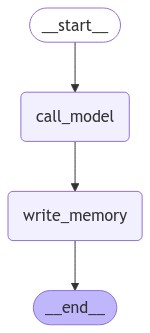

In [22]:
from IPython.display import Image, display

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Schema 
class UserProfile(BaseModel):
    """ Profile of a user """
    user_name: str = Field(description="The user's preferred name")
    user_location: str = Field(description="The user's location")
    interests: list = Field(description="A list of the user's interests")

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile", # Enforces use of the UserProfile tool
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Extraction instruction
TRUSTCALL_INSTRUCTION = """Create or update the memory (JSON doc) to incorporate information from the following conversation:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Location: {memory_dict.get('user_location', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"      
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
        
    # Get the profile as the value from the list, and convert it to a JSON doc
    existing_profile = {"UserProfile": existing_memory.value} if existing_memory else None
    
    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)]+state["messages"], "existing": existing_profile})
    
    # Get the updated profile as a JSON object
    updated_profile = result["responses"][0].model_dump()

    # Save the updated profile
    key = "user_memory"
    store.put(namespace, key, updated_profile)

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [23]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hello, Lance! It's nice to meet you. How can I assist you today?


In [24]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That sounds like a great way to explore the city! San Francisco has some beautiful routes and views. Do you have any favorite trails or spots you like to visit while biking?


In [25]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'value': {'user_name': 'Lance',
  'user_location': 'San Francisco',
  'interests': ['biking']},
 'key': 'user_memory',
 'namespace': ['memory', '1'],
 'created_at': '2024-11-04T23:51:17.662428+00:00',
 'updated_at': '2024-11-04T23:51:41.697652+00:00'}

In [26]:
# The user profile saved as a JSON object
existing_memory.value

{'user_name': 'Lance',
 'user_location': 'San Francisco',
 'interests': ['biking']}

In [27]:
# User input 
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
================================== Ai Message ==================================

Biking and visiting bakeries sounds like a delightful combination! San Francisco has some fantastic bakeries. Do you have any favorites, or are you looking for new recommendations to try out?


Continue the conversation in a new thread.

在新线程中继续对话。



In [28]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="What bakeries do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries do you recommend for me?
================================== Ai Message ==================================

Since you're in San Francisco and enjoy going to bakeries, here are a few recommendations you might like:

1. **Tartine Bakery** - Known for its delicious bread and pastries, it's a must-visit for any bakery enthusiast.
2. **B. Patisserie** - Offers a delightful selection of French pastries, including their famous kouign-amann.
3. **Arsicault Bakery** - Renowned for its croissants, which have been praised as some of the best in the country.
4. **Craftsman and Wolves** - Known for their inventive pastries and the "Rebel Within," a savory muffin with a soft-cooked egg inside.
5. **Mr. Holmes Bakehouse** - Famous for their cruffins and other creative pastries.

These spots should offer a great variety of treats for you to enjoy. Happy bakery hopping!


Trace:

https://smith.langchain.com/public/f45bdaf0-6963-4c19-8ec9-f4b7fe0f68ad/r

## 工作室（Studio）

![Screenshot 2024-10-30 at 11.26.31 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/6732d0437060f1754ea79908_Screenshot%202024-11-11%20at%207.48.53%E2%80%AFPM.png)

